In [1]:
"""
Author: Will Chen
Date: 8/2/2021
Purpose: 
1. With given products, structure a mean-revertion portfolio with least amount of variance
2. Try two different OLS approaches: regularized OLS from sklearn and normal OLS from statsmodels
Python version: 3.8.10
Pandas version: 1.2.5 
"""

'\nAuthor: Will Chen\nDate: 8/2/2021\nPurpose: \n1. With given products, structure a mean-revertion portfolio with least amount of variance\n2. Try two different OLS approaches: regularized OLS from sklearn and normal OLS from statsmodels\nPython version: 3.8.10\nPandas version: 1.2.5 \n'

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor ## one approach for multicollinearity handling
from sklearn.linear_model import ElasticNet ## another approach for multicollinearity handling, feature selection, regularization
import yfinance as yf

## Read in time series and run exploratory data analysis

                        XLB     XLE     XLF      XLI     XLP      XLK     XLU  \
2021-06-01 08:35:00  88.515  53.995  38.435  106.185  71.125  138.920  65.135   
2021-06-01 08:40:00  88.085  53.655  38.225  105.905  71.055  139.005  65.195   
2021-06-01 08:45:00  88.150  53.995  38.255  105.935  70.905  138.985  65.135   
2021-06-01 08:50:00  88.055  54.035  38.265  105.895  70.865  138.805  64.935   
2021-06-01 08:55:00  88.165  53.975  38.325  106.045  70.955  138.575  64.975   

                        XHB  
2021-06-01 08:35:00  75.640  
2021-06-01 08:40:00  75.280  
2021-06-01 08:45:00  75.210  
2021-06-01 08:50:00  75.120  
2021-06-01 08:55:00  75.315  


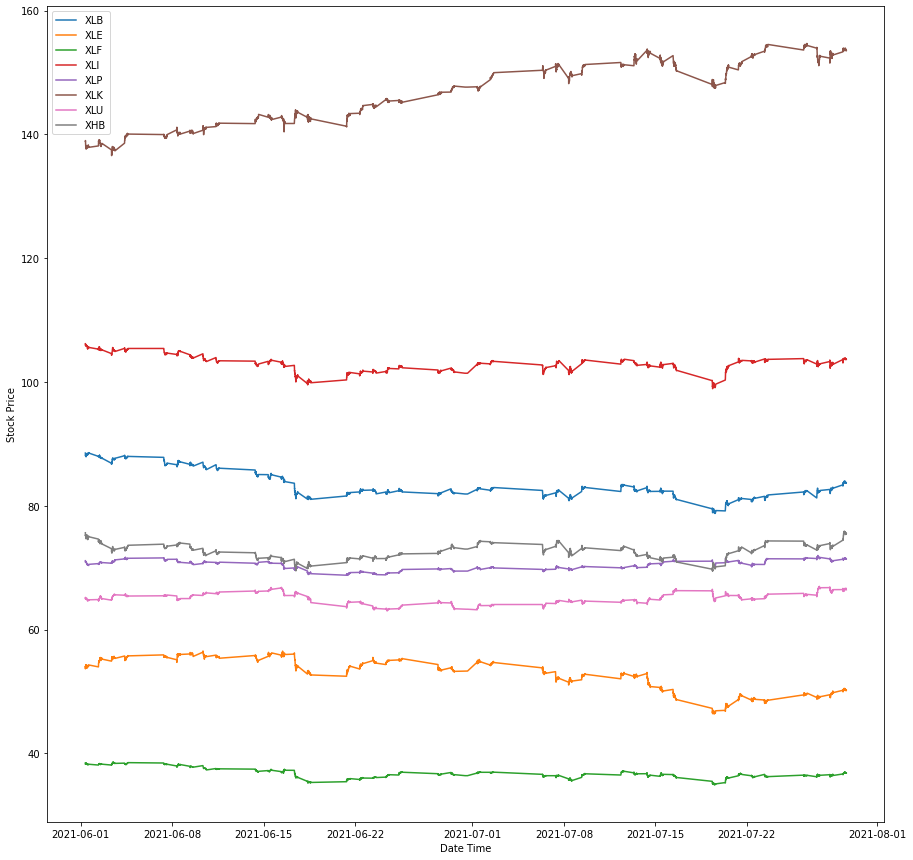


Ticker:  XLB
The corresponding equity name is:  Materials Select Sector SPDR Fund

Ticker:  XLE
The corresponding equity name is:  Energy Select Sector SPDR Fund

Ticker:  XLF
The corresponding equity name is:  Financial Select Sector SPDR Fund

Ticker:  XLI
The corresponding equity name is:  Industrial Select Sector SPDR Fund

Ticker:  XLP
The corresponding equity name is:  Consumer Staples Select Sector SPDR Fund

Ticker:  XLK
The corresponding equity name is:  Technology Select Sector SPDR Fund

Ticker:  XLU
The corresponding equity name is:  Utilities Select Sector SPDR Fund

Ticker:  XHB
The corresponding equity name is:  SPDR Series Trust - SPDR S&P Homebuilders ETF


'\nThoughts:\n1. These equities are ETFs corresponding to different sectors in SP500.\n2. Investors usually filter pair trading candidates from the same industry group or sub-industry group within which\ncompanies tend to share similar fundamental return driver. \n'

In [3]:
## read in time series using pandas
df=pd.read_excel('data.xls',index_col=0)

## overview of the data
print(df.head())

## simple plot of the time series
plt.figure(figsize=(15,15))
plt.plot(df)
plt.ylabel('Stock Price')
plt.xlabel('Date Time')
plt.legend(df.columns)
plt.show()

# retrieve the names of the equities using yahoo finance API
for ticker in df.columns:
    print('\nTicker: ', ticker)
    print('The corresponding equity name is: ', yf.Ticker(ticker).info['longName'])
"""
Thoughts:
1. These equities are ETFs corresponding to different sectors in SP500.
2. Investors usually filter pair trading candidates from the same industry group or sub-industry group within which
companies tend to share similar fundamental return driver. 
"""

## Test individual time series for stationarity

In [4]:
## test the stationarity of time series with a 0.01 cutoff value for p value
def test_stationarity(ts1,pValueCutoff=0.01):
    print('Below is the result for stationarity test:')
    pValueTest=adfuller(ts1)[1]
    if pValueTest<pValueCutoff:
        print('P value is: ', pValueTest)
        print('Reject the null hypothesis and hence stationary')
        return True
    else:
        print('P value is: ', pValueTest)
        print('Cannot reject the null hypothesis and hence non-stationary')
        return False

## run ADF test on each of the time series to check stationarity
for index_name in df.columns:
    print('\nFor %s'%(index_name))
    test_stationarity(df[index_name])
"""
Thoughts:
1. With a cutoff value of 0.01 for the p value, the price time series of all the selected equities are considered NON-stationary
2. Non-stationarity is the pre-requirement for the next step co-integration test.
"""


For XLB
Below is the result for stationarity test:
P value is:  0.17616056173271044
Cannot reject the null hypothesis and hence non-stationary

For XLE
Below is the result for stationarity test:
P value is:  0.7855619351940579
Cannot reject the null hypothesis and hence non-stationary

For XLF
Below is the result for stationarity test:
P value is:  0.1571163627479671
Cannot reject the null hypothesis and hence non-stationary

For XLI
Below is the result for stationarity test:
P value is:  0.019470667055667856
Cannot reject the null hypothesis and hence non-stationary

For XLP
Below is the result for stationarity test:
P value is:  0.45582573810322125
Cannot reject the null hypothesis and hence non-stationary

For XLK
Below is the result for stationarity test:
P value is:  0.738869117017642
Cannot reject the null hypothesis and hence non-stationary

For XLU
Below is the result for stationarity test:
P value is:  0.5009474181251097
Cannot reject the null hypothesis and hence non-station

'\nThoughts:\n1. With a cutoff value of 0.01 for the p value, the price time series of all the selected equities are considered NON-stationary\n2. Non-stationarity is the pre-requirement for the next step co-integration test.\n'

## Approach 1: Linear regression using sklearn and elasticnet for regularization, feature selection, and multicollinearity handling

In [5]:
def regularized_ols_error(X,y):
    regr=ElasticNet(random_state=100,alpha=0.1)
    regr.fit(X,y)
    error=y-regr.predict(X)
    ## provide an indicator for next step so that only results with stationary error will be selected
    if test_stationarity(error):
        stationarity_ind=1
    else:
        stationarity_ind=0
    return stationarity_ind, regr.coef_, np.cov(error)

## regress each one of the securities against all the other securities and select the one with the lowest error variance as the
## y security
min_variance=float('inf')
for y_ticker in df.columns:
    print('\nRegression for ',y_ticker)
    x_tickers=set(df.columns)-set([y_ticker])
    temp_ind, temp_coef, temp_covariance=regularized_ols_error(df[x_tickers].copy(),df[y_ticker].copy())
    if temp_ind==1 and temp_covariance<min_variance:
        min_variance=temp_covariance
        selected_y=y_ticker
        selected_x=x_tickers
        selected_coef=temp_coef

## summarize the linear regression
print('\nWhen using regularized OLS, below is the result: ')
print('The selected y equity is: ', selected_y)
selected_x=pd.DataFrame(selected_coef, index=selected_x,columns=['coefficient'])
selected_x=selected_x[(selected_x.coefficient>0.0001) | (selected_x.coefficient<-0.0001)]
print('The selected x equities and their coefficients are: ')
print(selected_x)

## generate pair trading portfolio that corresponds to the smallest portfolio variance
print('\nThe proposed pair trading portfolio is: ')
print('Long 1 share of %s'%(selected_y))
for i in range(len(selected_x)):
    if selected_x.iloc[i,0]>0:
        print('Short %f share of %s'%(selected_x.iloc[i,0], selected_x.index[i]))
    else:    
        print('Long %f share of %s'%(-selected_x.iloc[i,0], selected_x.index[i]))
        
print('\nThe variance of the proposed pair trading portfolio is: ',min_variance)



Regression for  XLB
Below is the result for stationarity test:
P value is:  0.018825615429736996
Cannot reject the null hypothesis and hence non-stationary

Regression for  XLE
Below is the result for stationarity test:
P value is:  0.011322867921475688
Cannot reject the null hypothesis and hence non-stationary

Regression for  XLF
Below is the result for stationarity test:
P value is:  0.008848105759328767
Reject the null hypothesis and hence stationary

Regression for  XLI
Below is the result for stationarity test:
P value is:  0.016084163331478694
Cannot reject the null hypothesis and hence non-stationary

Regression for  XLP
Below is the result for stationarity test:
P value is:  0.0008577980524434354
Reject the null hypothesis and hence stationary

Regression for  XLK
Below is the result for stationarity test:
P value is:  0.08866164609497168
Cannot reject the null hypothesis and hence non-stationary

Regression for  XLU
Below is the result for stationarity test:
P value is:  0.0

## Approach 2: Linear regression using statsmodels and variance inflation factor for multicollinearity handling

In [6]:
def normal_ols_error(X_in,y):
    X=sm.add_constant(X_in)
    ## select x equities with VIF lower than 10
    vif_output=pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])], index=X.columns)
    selected=list(vif_output[vif_output<10].index)
    X=sm.add_constant(X_in[selected])
    ## make sure the vif of selected x equities are lower than 10
    vif_output=pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])], index=X.columns)
    ## run linear regression model
    model=sm.OLS(y,X)
    regr=model.fit()
    error=y-regr.predict(X)
    ## provide an indicator for next step so that only results with stationary error will be selected
    if test_stationarity(error):
        stationarity_ind=1
    else:
        stationarity_ind=0
    return stationarity_ind, pd.DataFrame(regr.params.iloc[1:]), np.cov(error)

## regress each one of the securities against all the other securities and select the one with the lowest error variance as the
## y security
min_variance=float('inf')
for y_ticker in df.columns:
    print('\nRegression for ',y_ticker)
    x_tickers=set(df.columns)-set([y_ticker])
    temp_ind, temp_coef, temp_covariance=normal_ols_error(df[x_tickers].copy(),df[y_ticker].copy())
    if temp_ind==1 and temp_covariance<min_variance:
        min_variance=temp_covariance
        selected_y=y_ticker
        selected_x=temp_coef.index.values
        selected_coef=temp_coef.values

## summarize the linear regression
print('\nWhen using OLS, below is the result: ')
print('The selected y equity is: ', selected_y)
selected_x=pd.DataFrame(selected_coef, index=selected_x,columns=['coefficient'])
selected_x=selected_x[(selected_x.coefficient>0.0001) | (selected_x.coefficient<-0.0001)]
print('The selected x equities and their coefficients are: ')
print(selected_x)

## generate pair trading portfolio that corresponds to the smallest portfolio variance
print('\nThe proposed pair trading portfolio is: ')
print('Long 1 share of %s'%(selected_y))
for i in range(len(selected_x)):
    if selected_x.iloc[i,0]>0:
        print('Short %f share of %s'%(selected_x.iloc[i,0], selected_x.index[i]))
    else:    
        print('Long %f share of %s'%(-selected_x.iloc[i,0], selected_x.index[i]))
        
print('\nThe variance of the proposed pair trading portfolio is: ',min_variance)

"""
Thoughts:
1. Both regularized OLS and normal OLS select XLF as the y security because its regression error is stationary and has the 
lowest variance.
2. However, the proposed pair trading portfolios are different for these two approaches. 
"""


Regression for  XLB
Below is the result for stationarity test:
P value is:  0.047572923322451166
Cannot reject the null hypothesis and hence non-stationary

Regression for  XLE
Below is the result for stationarity test:
P value is:  0.042276609151949834
Cannot reject the null hypothesis and hence non-stationary

Regression for  XLF
Below is the result for stationarity test:
P value is:  0.0001514913039494667
Reject the null hypothesis and hence stationary

Regression for  XLI
Below is the result for stationarity test:
P value is:  0.23538658331062057
Cannot reject the null hypothesis and hence non-stationary

Regression for  XLP
Below is the result for stationarity test:
P value is:  0.01013206416809452
Cannot reject the null hypothesis and hence non-stationary

Regression for  XLK
Below is the result for stationarity test:
P value is:  0.04955327456490888
Cannot reject the null hypothesis and hence non-stationary

Regression for  XLU
Below is the result for stationarity test:
P value

'\nThoughts:\n1. Both regularized OLS and normal OLS select XLF as the y security because its regression error is stationary and has the lowest\nvariance.\n2. However, the proposed pair trading portfolios are different for these two approaches. \n'

## Summary
1. The basic approach used in this project to identify candidates and propose portfolio for pair trading is as follows:
    1.1. Select equities with price movements that are Non-stationary
    1.2. Run regression between one security and other securities to see if the regression residual is stationary
    1.3. Repeat 1.2 step over all the securities provided and select the regression that satisfy the following two conditions:
the regression residual is stationary and the variance of the regression residual is the smallest
    1.4. Propose a portfolio for pair trading based on the regression coefficient
2. For the regression part in step 1.2, I have tried two approaches: regularized OLS from sklearn module and normal OLS from statsmodels module. Both regularized OLS and normal OLS select XLF as the y security because its regression error is stationary and has the lowest variance. However, the proposed pair trading portfolios are different for these two approaches and the portfolio selected by normal OLS has lower variance for regression residual, which is normal.
3. What hasn't been done in this code due to time limitation: 
    3.1. The time series was not split into training and test set so that independent testing can be run on the test set.
    3.2. Hyperparameter tuning is not done on the regularized OLS, which could lead to a better model.